In [1]:
from matplotlib import pyplot as plt
from itertools import product
import numpy as np
import pandas as pd
import os

In [2]:
import rasterio as rio
from rasterio.plot import show
from rasterio import plot
from rasterio import windows
import imageio
from skimage import filters
from skimage.data import camera
from skimage.util import compare_images
from scipy.cluster.vq import whiten
from sklearn.cluster import KMeans

In [3]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [4]:
# set working directory
path = 'C:/Users/Changwha/Documents/02_UTK/03_2022FALL/COSC522/FinalProject'
os.chdir(path)
os.getcwd()

'C:\\Users\\Changwha\\Documents\\02_UTK\\03_2022FALL\\COSC522\\FinalProject'

Image number: urban-1
Class: urban
Filename: u_19TCG300905_0.JP2
Shape of data: (1000, 1000, 4)


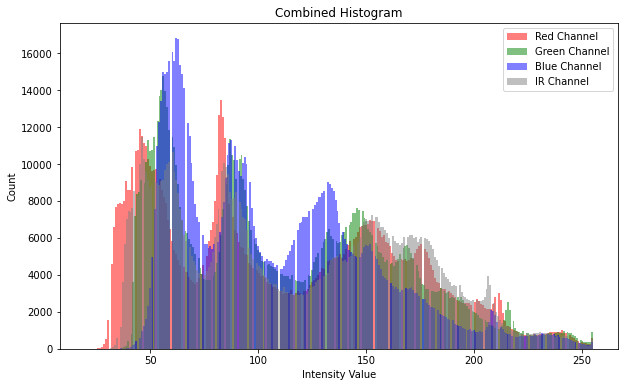

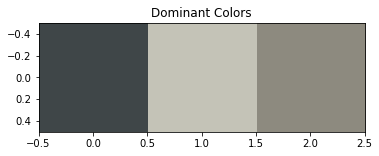

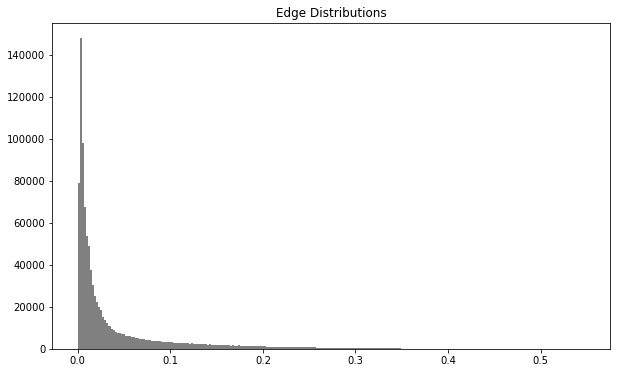

Image number: urban-2
Class: urban
Filename: u_19TCG300905_1.JP2
Shape of data: (1000, 1000, 4)


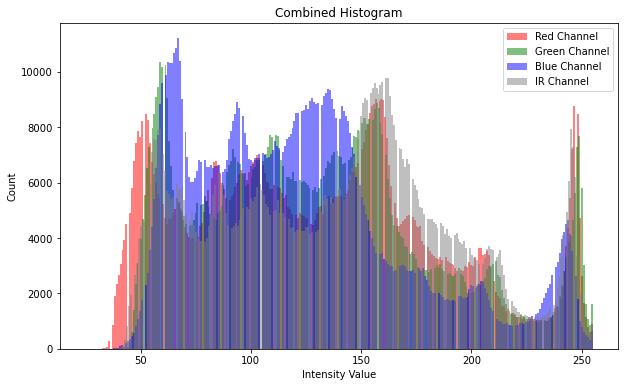

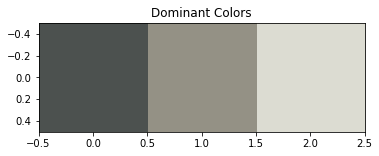

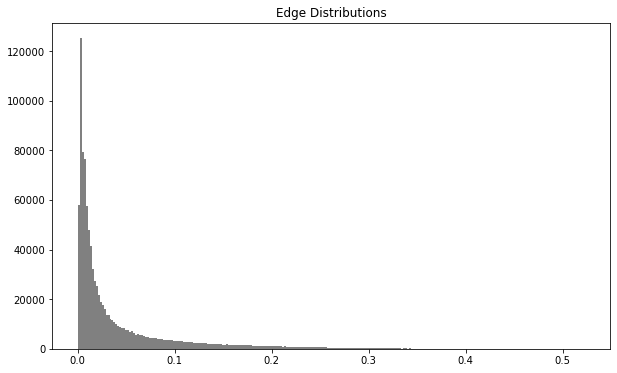

Image number: urban-3
Class: urban
Filename: u_19TCG300905_10.JP2
Shape of data: (1000, 1000, 4)


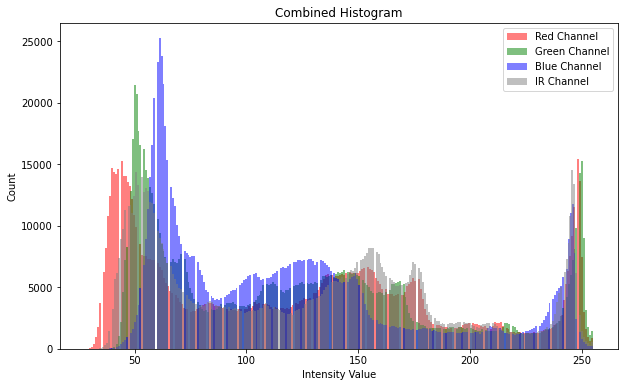

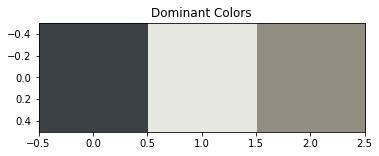

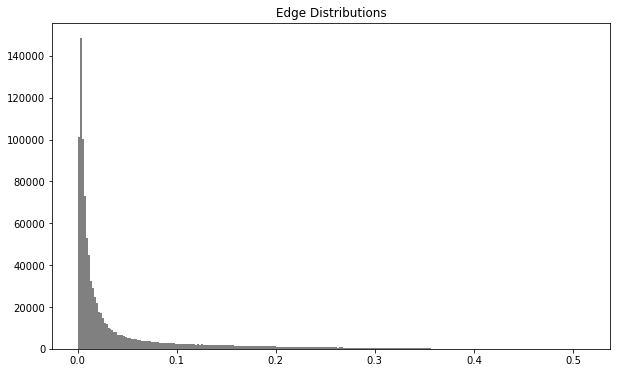

Image number: urban-4
Class: urban
Filename: u_19TCG300905_11.JP2
Shape of data: (1000, 1000, 4)


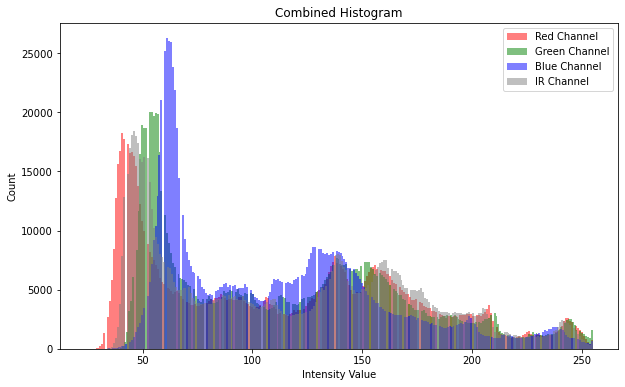

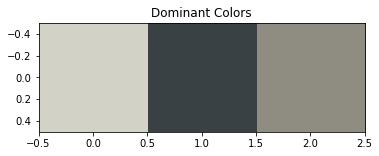

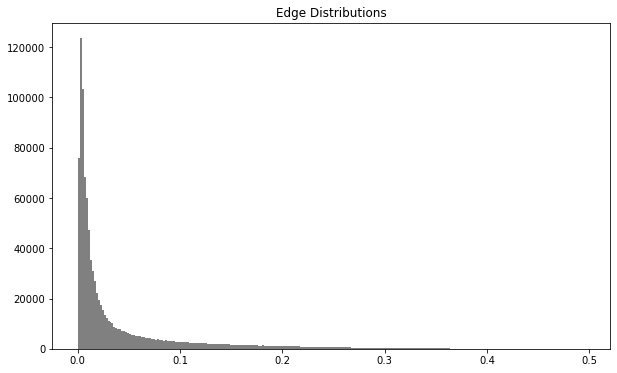

Image number: urban-5
Class: urban
Filename: u_19TCG300905_12.JP2


KeyboardInterrupt: 

In [20]:
labels = ['urban', 'suburb', 'rural', 'forest', 'water']
bands = ['red', 'green', 'blue', 'IR']
file_ls = []

# features
red_mean = []
red_median = []
red_std = []
green_mean = []
green_median = []
green_std = []
blue_mean = []
blue_median = []
blue_std = []
IR_mean = []
IR_median = []
IR_std = []
dom1_r = []
dom1_g = []
dom1_b = []
dom2_r = []
dom2_g = []
dom2_b = []
dom3_r = []
dom3_g = []
dom3_b = []
edge_mean = []
edge_median = []
edge_std = []

for label in labels:
    t = 1
    for f in os.listdir('{}/sampledata/splitdata/{}'.format(path, label)):
        print('Image number: {}-{}'.format(label, t))
        print('Class: {}'.format(label))
        print('Filename: {}'.format(f))
        file_ls.append(f)

        # read jp2
        imgjp2raw = rio.open('{}/sampledata/splitdata/{}/{}'.format(path, label, f))

        # convert structure
        imgjp2 = np.array(imgjp2raw.read())
        imgrshp = np.empty(shape = (1000, 1000, 4))
        dim = imgjp2.shape
        for k in range(dim[0]):
            for i in range(dim[1]):
                for j in range(dim[2]):
                    imgrshp[i][j][k] = np.int(imgjp2[k][i][j])
        del i, j, k
        print('Shape of data: {}'.format(imgrshp.shape))

        # get band features
        for band in bands:
            globals()['{}_channel'.format(band)] = imgrshp[:, :, bands.index(band)]
        
            globals()['{}_mean'.format(band)].append(np.mean(globals()['{}_channel'.format(band)]))
            globals()['{}_median'.format(band)].append(np.median(globals()['{}_channel'.format(band)]))
            globals()['{}_std'.format(band)].append(np.std(globals()['{}_channel'.format(band)]))

        plt.rcParams['figure.figsize'] = [10, 6]
        plt.hist(red_channel.ravel(), bins = 256, color = 'red', alpha = 0.5)
        plt.hist(green_channel.ravel(), bins = 256, color = 'green', alpha = 0.5)
        plt.hist(blue_channel.ravel(), bins = 256, color = 'blue', alpha = 0.5)
        plt.hist(IR_channel.ravel(), bins = 256, color = 'grey', alpha = 0.5)
        plt.xlabel('Intensity Value')
        plt.ylabel('Count')
        plt.legend(['Red Channel', 'Green Channel', 'Blue Channel', 'IR Channel'])
        plt.title('Combined Histogram')
        plt.show()

        # extract dominant colors
        r = []
        g = []
        b = []
        for row in imgrshp:
            for temp_r, temp_g, temp_b, temp_IR in row:
                r.append(temp_r)
                g.append(temp_g)
                b.append(temp_b)
        imgrshp_df = pd.DataFrame({'red': r, 'green': g, 'blue': b})
        imgrshp_df['scaled_color_red'] = whiten(imgrshp_df['red'])
        imgrshp_df['scaled_color_blue'] = whiten(imgrshp_df['blue'])
        imgrshp_df['scaled_color_green'] = whiten(imgrshp_df['green'])

        del r, g, b, row, temp_r, temp_g, temp_b, temp_IR

        kmeans = KMeans(n_clusters = 3)
        kmeans.fit(imgrshp_df[['scaled_color_red', 'scaled_color_green', 'scaled_color_blue']])
        dominant_colors = []
        redv_std, greenv_std, bluev_std = imgrshp_df[['red', 'green', 'blue']].std() # Get standard deviations of each color
        for cluster_center in kmeans.cluster_centers_:
            red_scaled, green_scaled, blue_scaled = cluster_center
            dominant_colors.append((red_scaled * redv_std / 255, green_scaled * greenv_std / 255, blue_scaled * bluev_std / 255)) # Convert each standardized value to scaled value

        c_ls = ['r', 'g', 'b']
        for i in [1, 2, 3]:
            for c in c_ls:
                globals()['dom{}_{}'.format(i, c)].append(dominant_colors[i - 1][c_ls.index(c)])

        del cluster_center, i, c, c_ls

        plt.rcParams['figure.figsize'] = [6, 2]
        plt.title('Dominant Colors')
        plt.imshow([dominant_colors])
        plt.show()

        # get edge features
        edge_sobel = filters.sobel(imgjp2raw.read([4][0]))
        plt.rcParams['figure.figsize'] = [10, 6]
        plt.title('Edge Distributions')
        plt.hist(edge_sobel.ravel(), bins = 256, color = 'grey')
        plt.show()

        edge_mean.append(np.mean(edge_sobel))
        edge_median.append(np.median(edge_sobel))
        edge_std.append(np.std(edge_sobel))

        t = t + 1

In [6]:
feat_dict = {'R_mean': red_mean, 'R_median': red_median, 'R_std': red_std, 
             'G_mean': green_mean, 'G_median': green_median, 'G_std': green_std, 
             'B_mean': blue_mean, 'B_median': blue_median, 'B_std': blue_std, 
             'IR_mean': IR_mean, 'IR_median': IR_median, 'IR_std': IR_std, 
             'DomCol1_R': dom1_r, 'DomCol1_G': dom1_g, 'DomCol1_B': dom1_b, 
             'DomCol2_R': dom2_r, 'DomCol2_G': dom2_g, 'DomCol2_B': dom1_b, 
             'Edge_mean': edge_mean, 'Edge_median': edge_median, 'Edge_std': edge_std}

df_feat = pd.DataFrame(feat_dict)
df_feat

R_mean  R_median      R_std      G_mean  G_median      G_std  \
0    111.396708     101.0  55.467373  113.494094     104.0  51.174587   
1    130.462005     128.0  56.275178  131.089981     127.0  53.464014   
2    123.419126     122.0  66.786855  124.449205     118.0  63.519577   
3    113.872066     110.0  59.903049  116.513835     112.0  55.969077   
4    117.388173     116.0  51.867623  120.222132     116.0  48.749108   
..          ...       ...        ...         ...       ...        ...   
495    1.169538       0.0   5.527995   17.045779      16.0   8.235218   
496    1.905751       0.0   8.503867   20.227269      18.0  12.160914   
497    3.700504       1.0  11.752981   24.069974      20.0  16.649175   
498    5.382330       1.0  14.977613   24.619945      19.0  20.730737   
499   65.449977      62.0  40.762542   74.912699      72.0  38.260794   

         B_mean  B_median      B_std     IR_mean  ...     IR_std  DomCol1_R  \
0    108.889444      99.0  44.903815  116.004962  ...  53.896826   0.550403   
1    123.716461     119.0  49.614962  138.609282  ...  54.016600   0.300918   
2    119.827851     109.0  58.235949  127.605122  ...  63.657113   0.571535   
3    112.213956     106.0  49.571834  116.227767  ...  58.048035   0.563336   
4    114.462490     108.0  43.462216  124.575508  ...  52.072476   0.515216   
..          ...       ...        ...         ...  ...        ...        ...   
495   43.195628      42.0   8.614011    0.378186  ...   3.577722   0.002680   
496   46.102000      44.0  12.554819    1.064880  ...   6.134051   0.003485   
497   48.169204      45.0  17.397465    2.552509  ...   8.553464   0.006004   
498   44.058449      39.0  20.756409    3.010436  ...  11.284341   0.008044   
499   75.921530      71.0  33.513288   84.963916  ...  59.746870   0.106688   

     DomCol1_G  DomCol1_B  DomCol2_R  DomCol2_G  DomCol2_B  Edge_mean  \
0     0.539466   0.496036   0.768535   0.762190   0.496036   0.040875   
1     0.318642   0.311809   0.584472   0.572483   0.311809   0.040899   
2     0.553611   0.505061   0.230142   0.254247   0.505061   0.040053   
3     0.556858   0.513233   0.230724   0.257962   0.513233   0.040955   
4     0.515429   0.474085   0.783256   0.783017   0.474085   0.038470   
..         ...        ...        ...        ...        ...        ...   
495   0.063814   0.166208   0.346768   0.553140   0.166208   0.002137   
496   0.073224   0.174459   0.104673   0.242564   0.174459   0.005527   
497   0.081686   0.175589   0.102572   0.235376   0.175589   0.011268   
498   0.077263   0.153738   0.104751   0.231691   0.153738   0.014610   
499   0.152049   0.179033   0.485349   0.508732   0.179033   0.049859   

     Edge_median  Edge_std  
0       0.013190  0.063164  
1       0.015251  0.059071  
2       0.011178  0.065619  
3       0.012745  0.063771  
4       0.013335  0.058552  
..           ...       ...  
495     0.000000  0.014282  
496     0.000000  0.023724  
497     0.002773  0.030989  
498     0.002192  0.041394  
499     0.035416  0.050987  

[500 rows x 21 columns]

In [8]:
df_feat.to_csv('{}/FeatureExtractions.csv'.format(path), encoding = 'cp949')

In [6]:
# read jp2 files (sample practice)
## samples:
## f_18TYM245935_10, r_18TYM365890_55, s_19TCG165890_95, u_19TCG300905_44, w_18TYM215875_78 ##
imgjp2raw = rio.open('{}/sampledata/splitdata/suburb/s_19TCG165890_95.jp2'.format(path))

(1000, 1000)

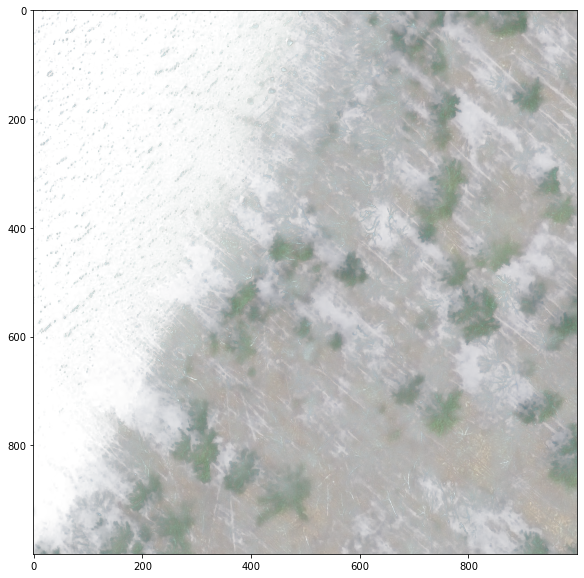

<AxesSubplot:>

In [35]:
plt.rcParams['figure.figsize'] = [10, 10]
plot.show(imgjp2raw.read())

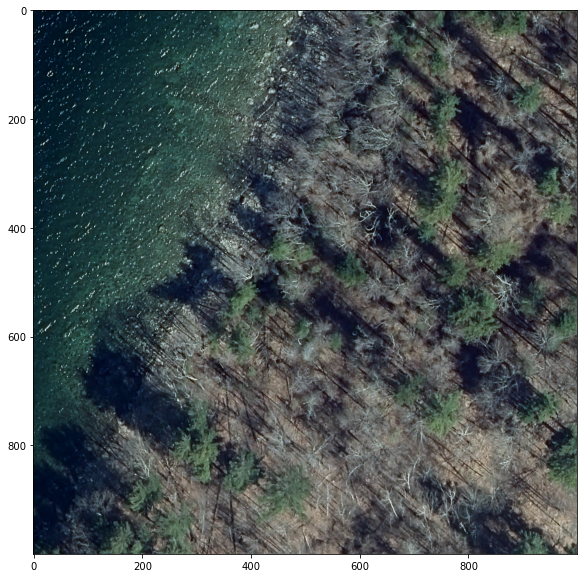

<AxesSubplot:>

In [36]:
plot.show(imgjp2raw.read([1, 2, 3]))

In [37]:
imgjp2 = np.array(imgjp2raw.read())
imgjp2.shape

(4, 1000, 1000)

In [10]:
imgrshp = np.empty(shape = (1000, 1000, 4))
dim = imgjp2.shape
for k in range(dim[0]):
    for i in range(dim[1]):
        for j in range(dim[2]):
            imgrshp[i][j][k] = np.int(imgjp2[k][i][j])

del i, j, k
imgrshp.shape

(1000, 1000, 4)

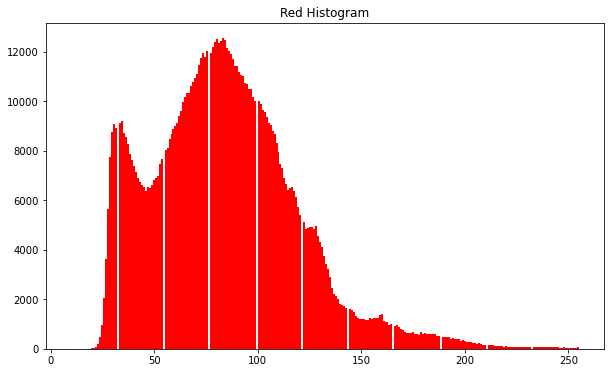

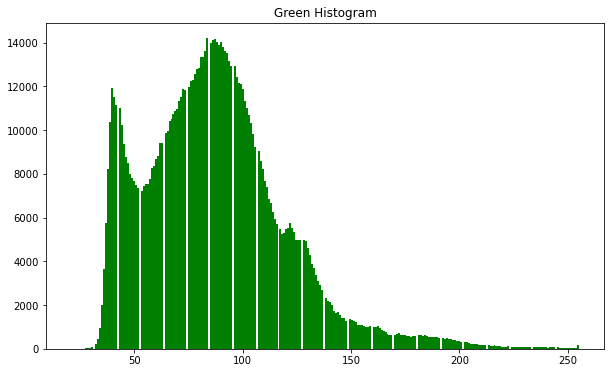

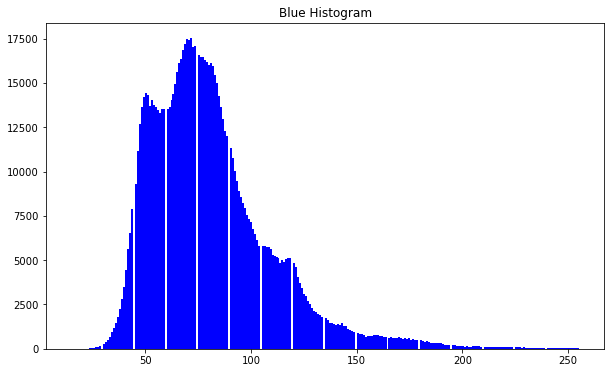

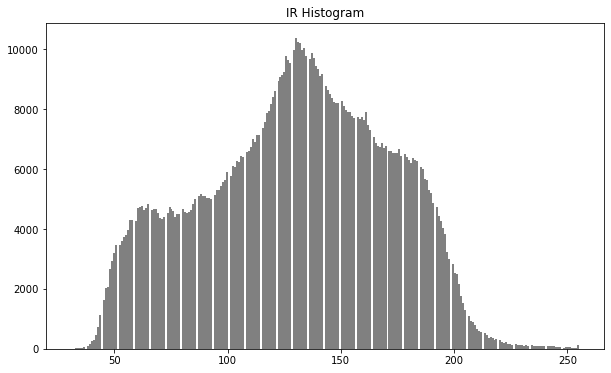

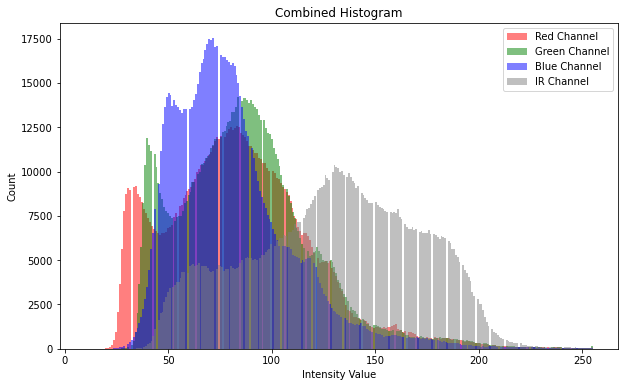

In [11]:
# Showing color intensity distribution in a histogram
plt.rcParams['figure.figsize'] = [10, 6]
# Obtain the red channel
red_channel = imgrshp[:, :, 0]
plt.hist(red_channel.ravel(), bins = 256, color = 'red') # with bins in a range of 256
plt.title('Red Histogram')
plt.show()

# Obtain the green channel
green_channel = imgrshp[:, :, 1]
plt.hist(green_channel.ravel(), bins = 256, color = 'green')
plt.title('Green Histogram')
plt.show()

# Obtain the blue channel
blue_channel = imgrshp[:, :, 2]
plt.hist(blue_channel.ravel(), bins = 256, color = 'blue')
plt.title('Blue Histogram')
plt.show()

# Obtain the IR channel
IR_channel = imgrshp[:, :, 3]
plt.hist(IR_channel.ravel(), bins = 256, color = 'grey')
plt.title('IR Histogram')
plt.show()

# Combined Histogram
plt.hist(red_channel.ravel(), bins = 256, color = 'red', alpha = 0.5)
plt.hist(green_channel.ravel(), bins = 256, color = 'green', alpha = 0.5)
plt.hist(blue_channel.ravel(), bins = 256, color = 'blue', alpha = 0.5)
plt.hist(IR_channel.ravel(), bins = 256, color = 'grey', alpha = 0.5)
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Red Channel', 'Green Channel', 'Blue Channel', 'IR Channel'])
plt.title('Combined Histogram')
plt.show()

In [12]:
print(np.mean(red_channel))
print(np.median(red_channel))
print(np.std(red_channel))
print(np.mean(green_channel))
print(np.median(green_channel))
print(np.std(green_channel))
print(np.mean(blue_channel))
print(np.median(blue_channel))
print(np.std(blue_channel))
print(np.mean(IR_channel))
print(np.median(IR_channel))
print(np.std(IR_channel))

84.24896
82.0
35.055404788968
87.412545
85.0
32.71288400039005
80.844495
76.0
29.10630181240782
129.825268
132.0
40.87761246364784


In [13]:
# alternative import method (only RGB)
imgrgb = imageio.imread('{}/sampledata/splitdatajpeg/u_19TCG300905_0.jpg'.format(path))
#plt.rcParams['figure.figsize'] = [10, 10]
#plt.imshow(imgrgb)

In [15]:
# standardizing pixel values
imgrshp_std = (imgrshp - np.mean(imgrshp, axis = (1, 2), keepdims = True)) / np.std(imgrshp, axis = (1, 2), keepdims = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


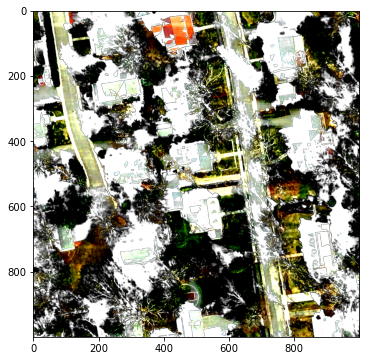

In [16]:
plt.imshow(imgrshp_std)

In [17]:
# Extract dominant colors
# Store RGB values of all pixels in lists r, g and b
r = []
g = []
b = []
for row in imgrshp:
    for temp_r, temp_g, temp_b, temp_IR in row:
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)
  
# only printing the size of these lists
# as the content is too big
print(len(r))
print(len(g))
print(len(b))
  
# Saving as DataFrame
imgrshp_df = pd.DataFrame({'red': r, 'green': g, 'blue': b})
  
# Scaling the values
imgrshp_df['scaled_color_red'] = whiten(imgrshp_df['red'])
imgrshp_df['scaled_color_blue'] = whiten(imgrshp_df['blue'])
imgrshp_df['scaled_color_green'] = whiten(imgrshp_df['green'])

del r, g, b, row, temp_r, temp_g, temp_b, temp_IR

1000000
1000000
1000000


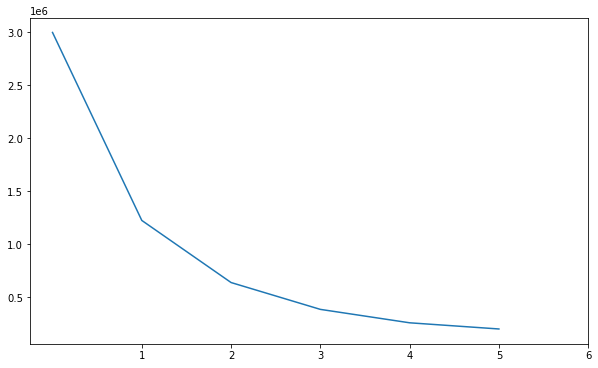

In [18]:
# OPTIONAL
# Preparing data to construct elbow plot
distortions = []
num_clusters = range(1, 7)  #range of cluster sizes

# Create a list of distortions from the kmeans function
for i in num_clusters:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(imgrshp_df[['scaled_color_red', 'scaled_color_blue', 'scaled_color_green']])
    distortions.append(kmeans.inertia_)
      
# Create a data frame with two lists, num_clusters and distortions
elbow_plot = pd.DataFrame({'num_clusters' : num_clusters, 'distortions' : distortions})
  
# Create a line plot of num_clusters and distortions
plt.rcParams['figure.figsize'] = [10, 6]
plt.plot(elbow_plot['distortions'])
plt.xticks(num_clusters)
plt.show()

In [19]:
kmeans.cluster_centers_

array([[1.8481021 , 2.19876867, 2.11916036],
       [3.7948333 , 4.23945901, 4.07963488],
       [1.11163276, 1.68281777, 1.41371159],
       [5.26221365, 6.03827133, 5.70402574],
       [3.04902613, 3.30727622, 3.27168445],
       [2.45041017, 2.70226618, 2.69799415]])

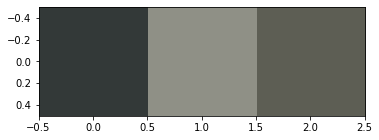

In [20]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(imgrshp_df[['scaled_color_red', 'scaled_color_green', 'scaled_color_blue']])
dominant_colors = []
  
# Get standard deviations of each color
red_std, green_std, blue_std = imgrshp_df[['red', 'green', 'blue']].std()
  
for cluster_center in kmeans.cluster_centers_:
    red_scaled, green_scaled, blue_scaled = cluster_center
  
    # Convert each standardized value to scaled value
    dominant_colors.append((red_scaled * red_std / 255, green_scaled * green_std / 255, blue_scaled * blue_std / 255))

del cluster_center

# Display colors of cluster centers
plt.rcParams['figure.figsize'] = [6, 2]
plt.imshow([dominant_colors])
plt.show()

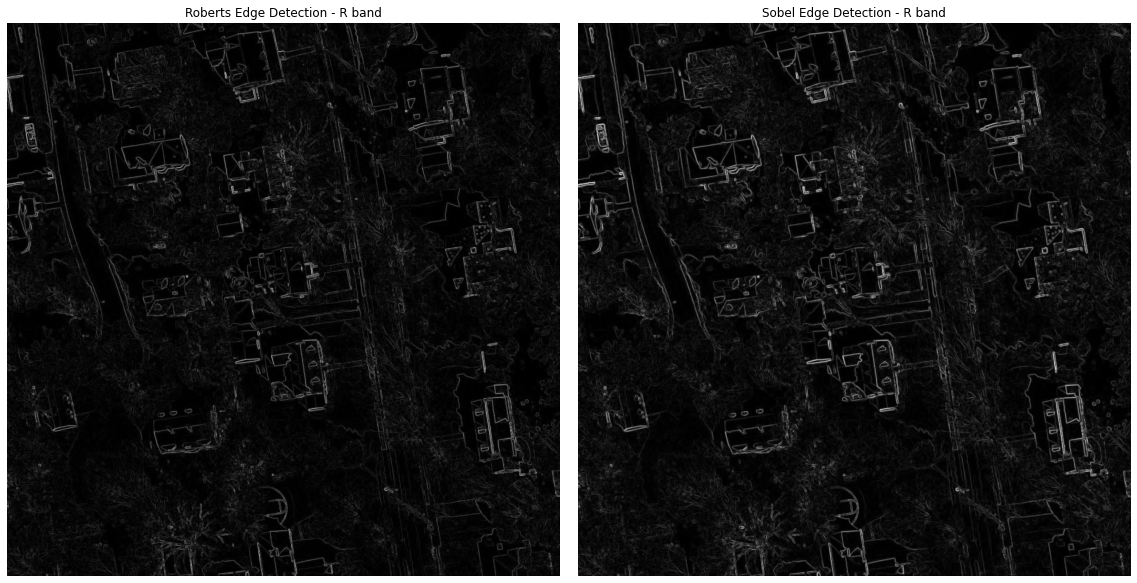

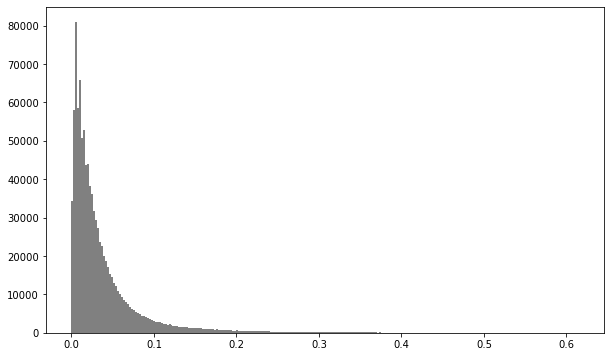

0.03777482443401296
0.022356380884296832
0.04840505013825753


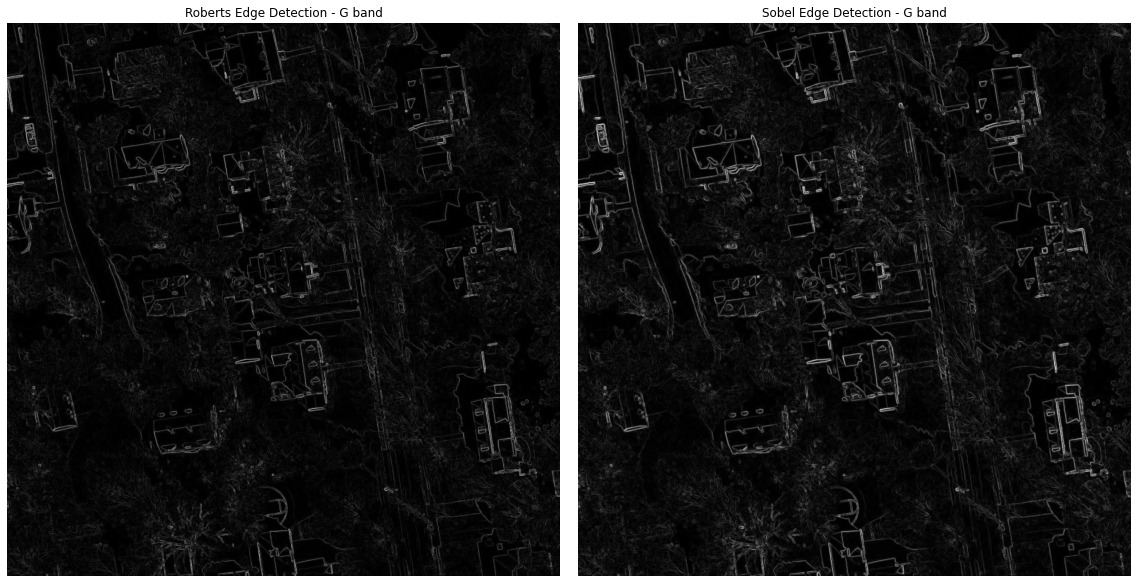

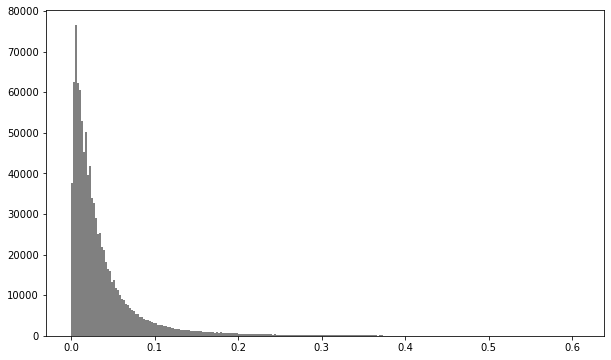

0.037414700221162944
0.022031573582592383
0.04821538894383472


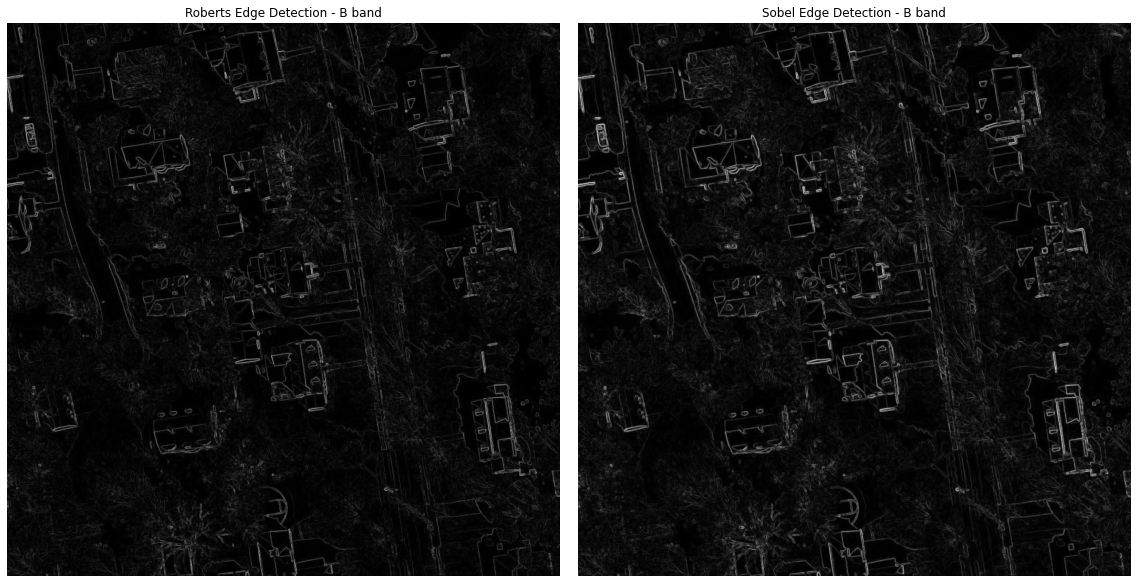

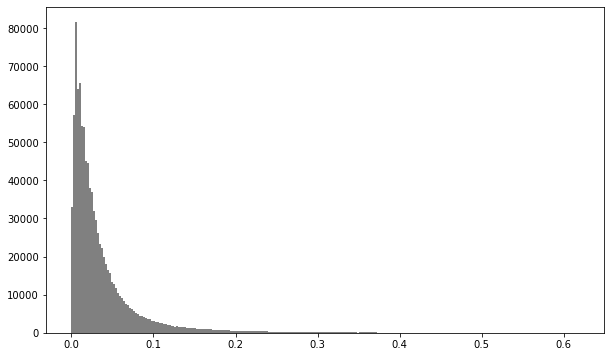

0.0372199985229509
0.021768238540367166
0.048112058229627754


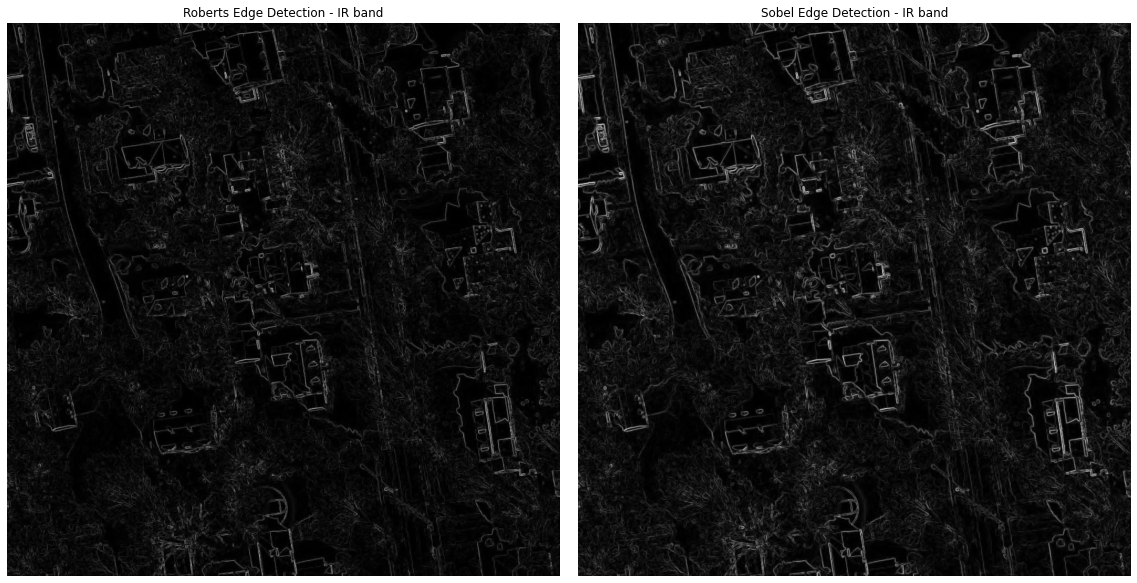

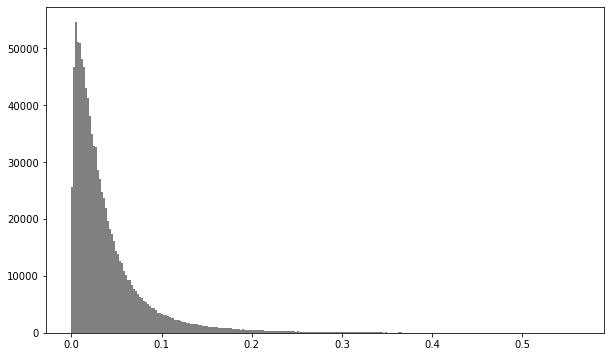

0.03947651522781988
0.025433572100142854
0.04515639175833961


In [21]:
# Edge detection
bands = ['R', 'G', 'B', 'IR']
for i in [1, 2, 3, 4]:
    edge_roberts = filters.roberts(imgjp2raw.read([i][0]))
    edge_sobel = filters.sobel(imgjp2raw.read([i][0]))

    fig, axes = plt.subplots(ncols = 2, sharex = True, sharey = True, figsize = (16, 8))

    axes[0].imshow(edge_roberts, cmap = plt.cm.gray)
    axes[0].set_title('Roberts Edge Detection - {} band'.format(bands[i - 1]))

    axes[1].imshow(edge_sobel, cmap = plt.cm.gray)
    axes[1].set_title('Sobel Edge Detection - {} band'.format(bands[i - 1]))

    for ax in axes:
        ax.axis('off')
    
    del ax

    plt.tight_layout()
    plt.show()

    plt.rcParams['figure.figsize'] = [10, 6]
    plt.hist(edge_sobel.ravel(), bins = 256, color = 'grey')
    plt.show()

    print(np.mean(edge_sobel))
    print(np.median(edge_sobel))
    print(np.std(edge_sobel))

del i

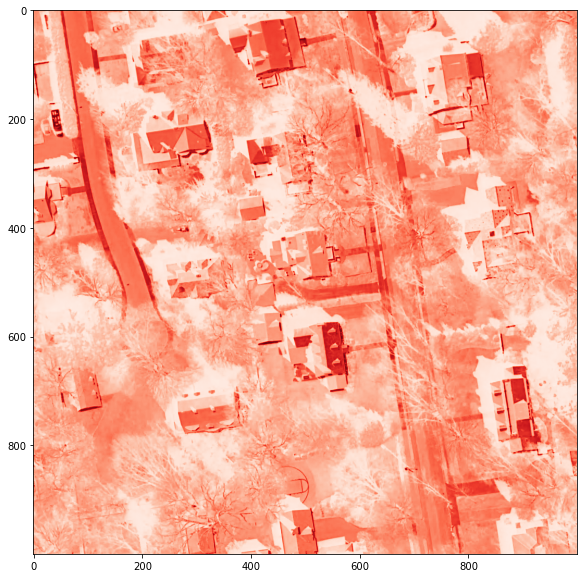

<AxesSubplot:>

In [22]:
# display the red band
plt.rcParams['figure.figsize'] = [10, 10]
plot.show(imgjp2raw.read([1]), cmap = 'Reds')

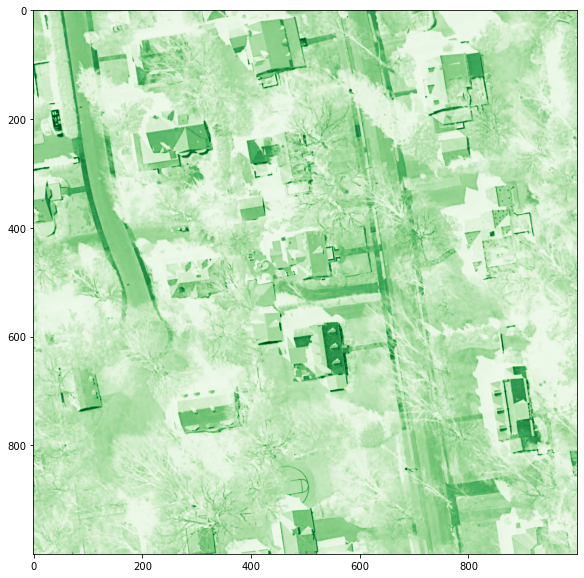

<AxesSubplot:>

In [23]:
# display the green band
plt.rcParams['figure.figsize'] = [10, 10]
plot.show(imgjp2raw.read([2]), cmap = 'Greens')

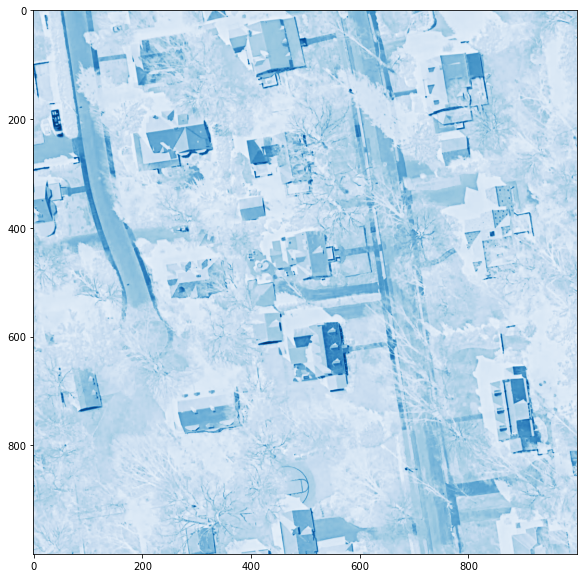

<AxesSubplot:>

In [24]:
# display the blue band
plt.rcParams['figure.figsize'] = [10, 10]
plot.show(imgjp2raw.read([3]), cmap = 'Blues')

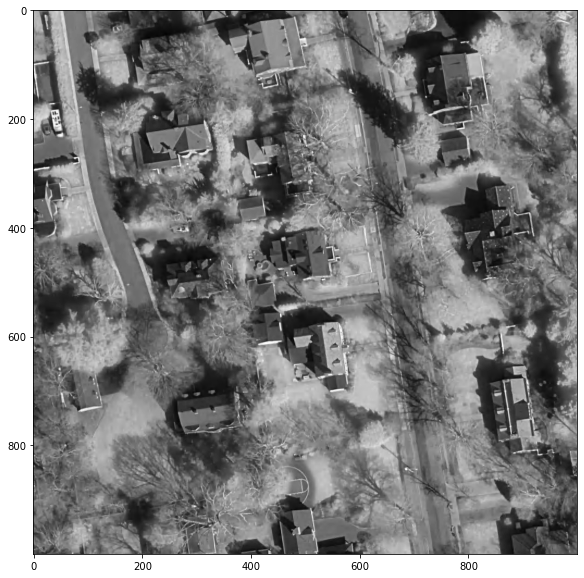

<AxesSubplot:>

In [25]:
# display the IR band
plot.show(imgjp2raw.read([4]), cmap = 'gray')

In [5]:
# Load features
df_feat = pd.read_csv('{}/FeatureExtractions.csv'.format(path), encoding = 'cp949')
del df_feat[df_feat.columns[0]]
df_feat = np.array(df_feat)

In [7]:
# Label
labels = ['urban', 'suburb', 'rural', 'forest', 'water']
df_labels = []
for label in labels:
    for i in range(0, 100):
        df_labels.append(label)
del label, i, labels
df_labels = np.array(df_labels)

In [14]:
# Modify classes
df_labels[[31, 55, 66, 77, 88, 99]] = 'water'
df_labels[[213, 228, 231, 238, 242, 246, 253, 257, 279, 290, 299]] = 'forest'
df_labels[[367, 309, 390, 391]] = 'water'
df_labels[[400, 435, 446, 457, 468, 477, 488, 499]] = 'forest'

In [15]:
# x: data sets, y: label sets
xtrain, xtest, ytrain, ytest = train_test_split(df_feat, df_labels, test_size = 0.30, random_state = 42)

In [18]:
# Random Forest
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(xtrain, ytrain)

## Cross-validation
rf_cv_scores = cross_val_score(rf_clf, xtrain, ytrain, cv = 10)
print('Average Cross Validation Score from Training:', rf_cv_scores.mean(), sep = '\n', end = '\n\n\n')

## Testing the model
rf_pred = rf_clf.predict(xtest)
rf_cm = confusion_matrix(ytest, rf_pred)
rf_cr = classification_report(ytest, rf_pred)
rf_accuracy = accuracy_score(ytest, rf_pred)

print('Confusion Matrix:', rf_cm, sep = '\n', end = '\n\n\n')
print('Test Statistics:', rf_cr, sep = '\n', end = '\n\n\n')
print('Testing Accuracy:', rf_accuracy)

Average Cross Validation Score from Training:
0.9457142857142857


Confusion Matrix:
[[33  1  0  0  1]
 [ 5 17  0  0  0]
 [ 0  0 23  0  0]
 [ 0  0  1 34  0]
 [ 0  0  0  0 35]]


Test Statistics:
              precision    recall  f1-score   support

      forest       0.87      0.94      0.90        35
       rural       0.94      0.77      0.85        22
      suburb       0.96      1.00      0.98        23
       urban       1.00      0.97      0.99        35
       water       0.97      1.00      0.99        35

    accuracy                           0.95       150
   macro avg       0.95      0.94      0.94       150
weighted avg       0.95      0.95      0.95       150



Testing Accuracy: 0.9466666666666667


In [24]:
# Support Vector Machine
svm_clf = SVC(kernel = 'linear', random_state = 0) # default kernel 'rbf' - radial basis function
# kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
svm_clf.fit(xtrain, ytrain)

## Cross-validation
svm_cv_scores = cross_val_score(svm_clf, xtrain, ytrain, cv = 10)
print('Average Cross Validation Score from Training:', svm_cv_scores.mean(), sep = '\n', end = '\n\n\n')

## Testing the model
svm_pred = svm_clf.predict(xtest)
svm_cm = confusion_matrix(ytest, svm_pred)
svm_cr = classification_report(ytest, svm_pred)
svm_accuracy = accuracy_score(ytest, svm_pred)

print('Confusion Matrix:', svm_cm, sep = '\n', end = '\n\n\n')
print('Test Statistics:', svm_cr, sep = '\n', end = '\n\n\n')
print('Testing Accuracy:', svm_accuracy)

Average Cross Validation Score from Training:
0.9400000000000001


Confusion Matrix:
[[32  2  1  0  0]
 [ 6 14  1  1  0]
 [ 0  0 23  0  0]
 [ 0  0  2 33  0]
 [ 0  0  0  0 35]]


Test Statistics:
              precision    recall  f1-score   support

      forest       0.84      0.91      0.88        35
       rural       0.88      0.64      0.74        22
      suburb       0.85      1.00      0.92        23
       urban       0.97      0.94      0.96        35
       water       1.00      1.00      1.00        35

    accuracy                           0.91       150
   macro avg       0.91      0.90      0.90       150
weighted avg       0.92      0.91      0.91       150



Testing Accuracy: 0.9133333333333333
